# Comparison between fitler array and wavelength scan

Neerja Aggarwal

Oct 24th, 2023

Let's imagine our object was spectrally constant. 
Compare the sampling approaches between Method 1: wavelength scan. and Method 2: filter array. 

## Import and Setup

In [1]:
# load relevant libraries
# activate pytorch conda environment on fuoco

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import image
import math
import os

from IPython import display # for refreshing plotting


/home/neerja/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set up to use the gpu
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
use_gpu = True
gpu = 1
if use_gpu:
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    torch.cuda.set_device(gpu)
    device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device('cpu') # uncomment this line to use cpu
torch.cuda.empty_cache()  #empty any variables in cache to free up space
print(device)


cuda:1


CHANGE experiment parameters here:

In [3]:
# set the following parameters
mag = 4 # 4x 
na_obj = 0.1 # low na objective 
pix_size_camera = 4 #  micron"

wv_start = 400e-3 # micron
wv_end = 800e-3 # micron
wv_step = 50e-3 # micron

# these are computed automatically
wv_range = np.arange(wv_start,wv_end, wv_step) # spectral channel center vector
Nw = len(wv_range)
pix_size_object =pix_size_camera/mag # micron  

# Create helper functions

In [4]:
# start with an image in the object plane
# let's load a high resolution res target and just upsample for now?  we'll just do a mini version with limited angles. 
path = '../../DATA/SpectralFPMData/usafrestarget.jpeg'
im = torch.from_numpy(image.imread(path))[:,:,0] # pick out the first channel


def preprocessObject(im):
    (Ny,Nx) = im.shape
    # make image square
    if Ny<Nx:
        im = im[:,1:Ny]
    elif Nx<Ny:
            im = im[1:Nx,:]
    # make even dimensions
    if Ny % 2 != 0:
        im = im[:-1,:]
    if Nx % 2 != 0:
        im = im[:,:-1]
    return im
def makeSpectralObject(im,spectrum):
    obj = torch.unsqueeze(im,0)
    obj = obj*spectrum
    return obj

im = preprocessObject(im)
(Ny,Nx) = im.shape
Npixel = Ny


In [5]:
# make into spectral object
spectrum = torch.ones([Nw,1,1])  # create a spectrum vector with dimension (Nw, 1,1)
spectral_im = im.unsqueeze(0)*spectrum  # elementwise multiply with the sample after expanding dim0 to be wavelength

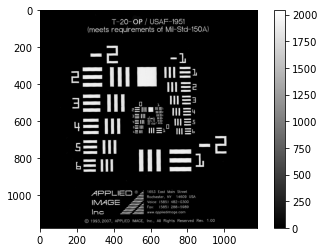

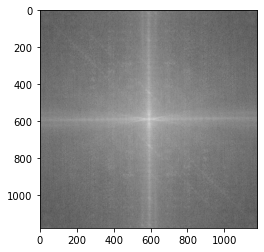

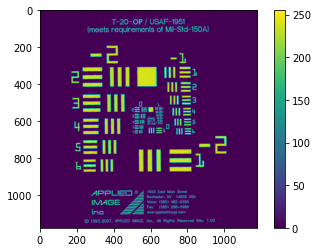

In [6]:
# look at image
sim_xy = torch.sum(spectral_im, dim=0)
plt.imshow(sim_xy,'gray')
plt.colorbar()


pup_obj = torch.fft.fftshift(torch.fft.fft2(sim_xy))
plt.figure()
plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')


# look at single channel
plt.figure()
sim_0 = spectral_im[0,:,:]
plt.imshow(sim_0)
plt.colorbar()


Text(0.5, 1.0, 'wv = 750nm')

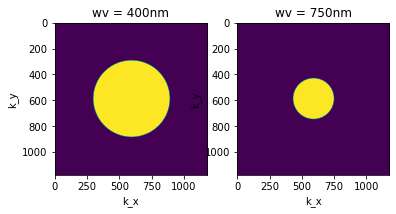

In [7]:
# make pupil mask
def createPupilStop(na_obj, wv, pix_size_object, Npixel):
    fPupilEdge = na_obj/wv # edge of pupipl is NA/wavelength
    fMax = 1/(2*pix_size_object)
    df = 1/(Ny*pix_size_object) # assume square image
    fvec = np.arange(-fMax,fMax,df)
    fxc,fyc = np.meshgrid(fvec,fvec)
    # caclulate radius of f coordinates
    frc = np.sqrt(fxc**2+fyc**2)
    pupil = np.zeros_like(frc) 
    pupil[frc<fPupilEdge] = 1 # make everything inside fPupilEdge transmit 100%
    return torch.Tensor(pupil)

pupilstack = torch.zeros([Nw,Ny,Nx])
for k in np.arange(Nw):
    wv = wv_range[k]
    pupilstack[k,:,:]  = createPupilStop(na_obj,wv,pix_size_object, Npixel)

k =0
plt.subplot(1,2,1)
plt.imshow(pupilstack[k,:,:])
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")

k=-1
plt.subplot(1,2,2)
plt.imshow(pupilstack[k,:,:])
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")

Text(0.5, 1.0, 'wv = 750nm')

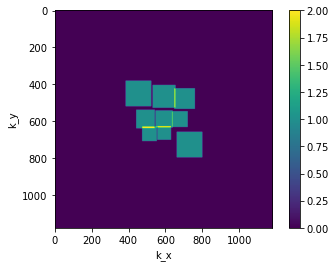

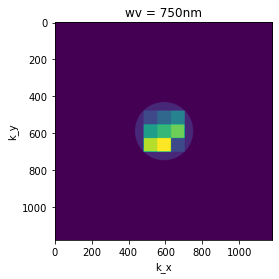

In [8]:
# make aperture
# let's say our apperture is defined in physical xy space?  Then it needs to be converted into kx, ky space for each wavelength. 

def createTile(Nw):
    a = np.arange(1,Nw+1) # get vector from 0 to Nw-1
    s = np.ceil(np.sqrt(Nw)).astype(int) # compute sqrt of number of channels and round up to the next integer.  Ex: sqrt(8)--> 3x3 matrix
    a = np.resize(a, (s,s))
    return(a)

def createApertureFromTile(a,na_obj,ind, wv, pix_size_object, Ny,Nx):
    df = 1/(Ny*pix_size_object)
    f_width = na_obj/wv*np.sqrt(2) # side of largest square that can fit in circle pupil 
    f_width_ind = np.floor(f_width/df).astype(int)
    mul_factor = int(f_width_ind/a.shape[0]) # assume you want square apperture
    aperture = np.repeat(np.repeat(a, mul_factor, axis = 0), mul_factor, axis = 1) # stretch the filter array

    # pad into appropriate size
    pady = int((Ny-f_width_ind)/2)+1
    padx = int((Nx-f_width_ind)/2)+1
    aperture = np.pad(aperture, ((pady, pady),(padx,padx)))
    aperture = aperture[0:Ny,0:Nx] # correct size
    if aperture.shape[0] != Ny or aperture.shape[1] != Nx:
        print('aperture matrix size incorrect!') # catch remaining error

    # pick out into channels
    frame = np.zeros((Ny,Nx))
    frame[np.where(aperture == ind)] = 1
    return (torch.Tensor(frame), torch.Tensor(aperture))


aperture_stack = torch.zeros([Nw,Ny,Nx])
tile = createTile(Nw) # motif for filter array. 
for k in np.arange(Nw):
    wv = wv_range[k]
    (aperture_stack[k,:,:], aperture) = createApertureFromTile(tile,na_obj,k+1, wv, pix_size_object, Ny,Nx)

plt.imshow(torch.sum(aperture_stack,axis = 0))
plt.colorbar()
plt.xlabel("k_x")
plt.ylabel('k_y')

k=-1
plt.figure()
plt.imshow(pupilstack[k,:,:]+aperture)
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")


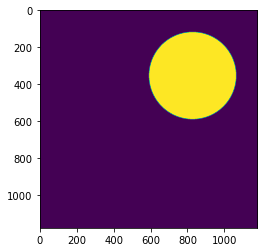

In [9]:
# given illumination angle, compute pupil stack. 

def createPupilfromIllum(illum_angle, wv):
    fPupilEdge = na_obj/wv # edge of pupipl is NA/wavelength
    fMax = 1/(2*pix_size_object)
    df = 1/(Ny*pix_size_object) # assume square image
    rady = illum_angle[0]
    radx = illum_angle[1]
    fy_shift = math.sin(rady)/wv
    fx_shift = math.sin(radx)/wv
    fvec_x = np.arange(-fMax,fMax,df) - fx_shift
    fvec_y = np.arange(-fMax,fMax,df) - fy_shift
    fxc,fyc = np.meshgrid(fvec_x,fvec_y)
    # caclulate radius of f coordinates
    frc = np.sqrt(fxc**2+fyc**2)
    pupil = np.zeros_like(frc) 
    pupil[frc<fPupilEdge] = 1 # make everything inside fPupilEdge transmit 100%
    return torch.Tensor(pupil)

# look at an example illumination field
illum_angle = (-.1,.1)  # y,x  # unit is in radians

p = createPupilfromIllum(illum_angle, wv=500e-3)

plt.imshow(p)

Text(0.5, 1.0, 'wv = 750nm')

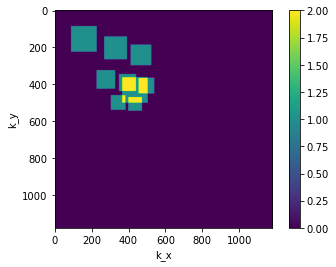

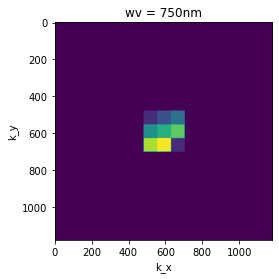

In [75]:
# given illumination angle, compute pupil stack. 

def createAperturefromIllum(a,na_obj,ind, wv, pix_size_object, Ny,Nx, illum_angle):
    df = 1/(Ny*pix_size_object)
    f_width = na_obj/wv*np.sqrt(2) # side of largest square that can fit in circle pupil 
    f_width_ind = np.floor(f_width/df).astype(int)
    mul_factor = int(f_width_ind/a.shape[0]) # assume you want square apperture
    aperture = np.repeat(np.repeat(a, mul_factor, axis = 0), mul_factor, axis = 1) # stretch the filter array

    rady = illum_angle[0]
    radx = illum_angle[1]
    fy_shift = math.sin(rady)/wv
    fx_shift = math.sin(radx)/wv
    fx_shift_ind = np.floor(fx_shift/df).astype(int)
    fy_shift_ind = np.floor(fy_shift/df).astype(int)
    # pad into appropriate size
    pady = int((Ny-f_width_ind)/2)+1
    padx = int((Nx-f_width_ind)/2)+1

    aperture = np.pad(aperture, ((pady, pady),(padx,padx)))
    aperture = aperture[0:Ny,0:Nx] # correct size
    if aperture.shape[0] != Ny or aperture.shape[1] != Nx:
        print('aperture matrix size incorrect!') # catch remaining error
    # pick out into channels
    frame = np.zeros((Ny,Nx))
    frame[np.where(aperture == ind)] = 1
    frame = torch.Tensor(frame)
    frame = torch.roll(frame, (fy_shift_ind, fx_shift_ind), dims = (0,1))
    
    if fy_shift_ind>pady:
        frame[0:fy_shift_ind-pady] = 0
    if fy_shift_ind<-pady:
        frame[fy_shift_ind-pady:] = 0
    if fx_shift_ind>padx:
        frame[0:fx_shift_ind-padx] = 0
    if fx_shift_ind<-padx:
        frame[fx_shift_ind-padx:] = 0
    
    return (torch.Tensor(frame), torch.Tensor(aperture))

# look at an example illumination field
illum_angle = (-.1,-.1)  # y,x  # unit is in radians

aperture_stack = torch.zeros([Nw,Ny,Nx])
tile = createTile(Nw) # motif for filter array. 
for k in np.arange(Nw):
    wv = wv_range[k]
    (aperture_stack[k,:,:], aperture) = createAperturefromIllum(tile,na_obj,k+1, wv, pix_size_object, Ny,Nx, illum_angle)

plt.imshow(torch.sum(aperture_stack,axis = 0))
plt.colorbar()
plt.xlabel("k_x")
plt.ylabel('k_y')

k=-1
plt.figure()
plt.imshow(aperture)
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")


Text(0, 0.5, 'Y')

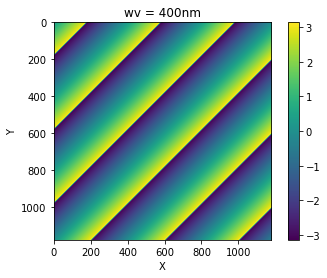

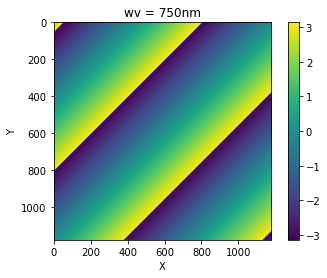

In [10]:
# create xy grid for object space (used for illumination field)
def createXYgrid(pix_size_object,Nx,Ny):
    xvec = np.arange(-pix_size_object*Nx/2,pix_size_object*Nx/2,pix_size_object)
    yvec = np.arange(-pix_size_object*Ny/2,pix_size_object*Ny/2,pix_size_object)
    xygrid = torch.Tensor(np.array(np.meshgrid(xvec,yvec)))
    return xygrid

# create the illumination field given angle of planewave
def createIllumField(xygrid, illum_angle, wv):
    rady = illum_angle[0]
    radx = illum_angle[1]
    k0 = 2*math.pi/wv
    ky = k0*math.sin(rady)
    kx = k0*math.sin(radx)
    field = torch.exp(1j*kx*xygrid[1] + 1j*ky*xygrid[0])
    return field

# look at an example illumination field
illum_angle = (.001,.001)  # y,x  # unit is in radians
xygrid = createXYgrid(pix_size_object,Nx,Ny)


# create stack of illum field
illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64)  # use complex dtype
for k in np.arange(Nw):
    wv = wv_range[k]
    illumstack[k,:,:] = createIllumField(xygrid,illum_angle,wv)

k=0
field = illumstack[k,:,:]
plt.figure()
plt.imshow(torch.angle(field))
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

k=-1
field = illumstack[k,:,:]
plt.figure()
plt.imshow(torch.angle(field))
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')


<Figure size 432x288 with 0 Axes>

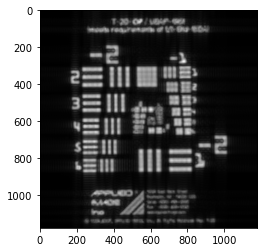

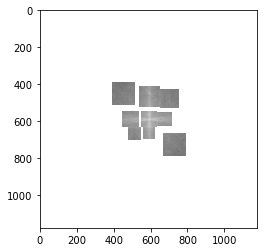

<Figure size 432x288 with 0 Axes>

In [11]:
# compute the measurement given an object and incident wave field and pupil stop
def forwardSFPM(objstack, pupilstack, illumstack, Nw):
    # multiply by the sample
    for k in torch.arange(Nw):
        obj = objstack[k]
        pupil = pupilstack[k]
        field = illumstack[k]
        obj_field = field*obj
        # take the fourier transform and center in pupil plane
        pup_obj = torch.fft.fftshift(torch.fft.fft2(obj_field))*pupil
        # multiply object's FFT with the pupil stop and take ifft to get measurement
        if k==0:
            y = torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
            pup_out = pup_obj 
        else:
            y = y+torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
            pup_out = pup_out + pup_obj 
        # subsample according to pixel size on camera?
    return (y, pup_out)

# look at an example measurement
(y, pup_obj) = forwardSFPM(spectral_im,aperture_stack, illumstack, Nw)
plt.imshow(torch.abs(y),'gray')
plt.figure()
plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')
plt.figure()


In [77]:
def samplePupil(objstack, pupil_illum_stack, Nw):
    pup_obj = torch.zeros_like(pupil_illum_stack,dtype = torch.complex64)
    for k in torch.arange(Nw):
        obj = objstack[k,:,:]
        pupil = pupil_illum_stack[k,:,:]
        pup_obj[k,:,:] = torch.fft.fftshift(torch.fft.fft2(obj))*(pupil)
    return pup_obj

In [13]:
# create list of illumination angles (leds) to turn on one at a time
def createlist_led(num_leds,minval,maxval):
    list_leds = np.random.uniform(low = minval, high = maxval, size = (num_leds,2))
    # append a (0,0) bf led
    list_leds = np.append(list_leds,np.zeros([1,2]), axis = 0 )
    return list_leds

## Simulate random measurements with Method 1
